# **Разработка моделей для предсказания  уровня удовлетворённости сотрудников и вероятности увольнения**

**HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.**

**Имеются данные от Компании с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 
Поставлены 2 задачи:**
- `Задача 1` - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- `Задача 2` - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

**Имеются файлы с данными:**
- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

## **Задача 1: предсказание уровня удовлетворённости сотрудника**

### Загрузка данных

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn -q

In [3]:
!pip install imbalanced-learn -q

In [4]:
!pip install shap -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import phik
import math
import shap
from phik import resources, report
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import randint
from math import sqrt
from math import factorial
from matplotlib import pyplot as plt
from scipy.stats import binom, norm
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix, 
    precision_score, 
    recall_score, 
    accuracy_score, 
    r2_score, 
    mean_squared_error, 
    mean_absolute_error,
    roc_auc_score,
    make_scorer,
    f1_score
)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [6]:
data_train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep = ',')
data_test_features = pd.read_csv('/datasets/test_features.csv', sep = ',')
data_test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep = ',')

In [7]:
def inf(df, r):
    df1=df.head(r)
    df2=df.info()
    return display(df1, df2)

In [8]:
inf(data_train_job, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


None

In [9]:
inf(data_test_features, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


None

In [10]:
inf(data_test_target, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


None

**Данные загружены, соответствуют описанию. Переходим к предобработке данных.**

### Предобработка данных

**В `data_train_job` и `data_test_features` есть несколько пропусков в столбцах dept и level, в `data_test_target` пропусков нет. Типы данных в столбцах соответствуют находящимся в них данным. Наименования столбцов не требуют изменений. Заполнение пропусков будет выполнено позже в пайплайне.**

**Проверим данные на наличие дубликатов.**

In [11]:
data_train_job.duplicated().sum()

0

In [12]:
data_test_features.duplicated().sum()

0

In [13]:
data_test_target.duplicated().sum()

0

**Объединим таблицы `data_test_features` и `data_test_target`.**

In [14]:
data_test = data_test_features.merge(data_test_target, on='id', how='inner')

In [15]:
inf(data_test, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1998 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               2000 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75
5,429973,purchasing,middle,medium,6,no,no,3,42000,0.67
6,850699,technology,junior,medium,3,no,no,3,26400,0.36
7,500791,sales,middle,high,9,no,no,4,49200,0.73
8,767867,marketing,middle,high,3,no,yes,4,62400,0.44
9,937235,sales,junior,medium,1,no,yes,3,26400,0.22


None

**По столбцам с типами данных object рассмотрим уникальные значения для проверки на наличие неявных дубликатов.**

In [16]:
for n in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    display(f'Уникальные значения data_train_job[{n}]:', sorted(data_train_job[n].unique(), key=str))
    display(f'Уникальные значения data_test[{n}]:', sorted(data_test[n].unique(), key=str))

'Уникальные значения data_train_job[dept]:'

['hr', 'marketing', nan, 'purchasing', 'sales', 'technology']

'Уникальные значения data_test[dept]:'

[' ', 'hr', 'marketing', nan, 'purchasing', 'sales', 'technology']

'Уникальные значения data_train_job[level]:'

['junior', 'middle', nan, 'sinior']

'Уникальные значения data_test[level]:'

['junior', 'middle', nan, 'sinior']

'Уникальные значения data_train_job[workload]:'

['high', 'low', 'medium']

'Уникальные значения data_test[workload]:'

[' ', 'high', 'low', 'medium']

'Уникальные значения data_train_job[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_test[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_train_job[last_year_violations]:'

['no', 'yes']

'Уникальные значения data_test[last_year_violations]:'

['no', 'yes']

**Неявных дубликатов не обнаружено, однако видим, что некоторые пропуски в `data_test` выглядят как пробел, что воспринимается как строковое значение. Устраним это.**

In [17]:
data_test['dept'] = data_test['dept'].replace(' ', np.nan)
data_test['workload'] = data_test['workload'].replace(' ', np.nan)

In [18]:
for n in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    display(f'Уникальные значения data_test[{n}]:', sorted(data_test[n].unique(), key=str))

'Уникальные значения data_test[dept]:'

['hr', 'marketing', nan, 'purchasing', 'sales', 'technology']

'Уникальные значения data_test[level]:'

['junior', 'middle', nan, 'sinior']

'Уникальные значения data_test[workload]:'

['high', 'low', 'medium', nan]

'Уникальные значения data_test[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_test[last_year_violations]:'

['no', 'yes']

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   dept                   1997 non-null   object 
 2   level                  1999 non-null   object 
 3   workload               1999 non-null   object 
 4   employment_years       2000 non-null   int64  
 5   last_year_promo        2000 non-null   object 
 6   last_year_violations   2000 non-null   object 
 7   supervisor_evaluation  2000 non-null   int64  
 8   salary                 2000 non-null   int64  
 9   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 171.9+ KB


**Видим теперь явные новые пропуски, которые будут заполнены далее в пайплайне. На данный момент предобработка данных завершена, переходим к исследовательскому анализу данных.**

### Исследовательский анализ данных

**Проведём исследовательский анализ данных из каждой таблицы. Проведём статистический анализ всех признаков в таблицах, построим графики для каждого признака. Для количественных признаков построим гистограммы и "ящики с усами", а для категориальных признаков - круговую диаграмму.**

In [20]:
data_train_job.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate'],
      dtype='object')

In [21]:
g1_hist = ['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
g2_hist = ['Отдел', 'Уровень занимаемой должности', 
           'Уровень загруженности сотрудника', 
           'Длительность работы в компании (в годах)', 
           'Повышение за последний год', 
           'Нарушения трудового договора',
           'Оценка качества работы сотрудника (руководителем)',
           'Ежемесячная зарплата сотрудника', 'Уровень удовлетворённости']
bins_hist = [30, 30, 30, 30, 30, 30, 30, 45, 25]

In [22]:
def hist_1(g1_hist, g2_hist, bins_hist, data_train_job, data_test):
    for n in range(len(g1_hist)):
        in_train = g1_hist[n] in data_train_job.columns
        in_test = g1_hist[n] in data_test.columns
        discr_sign = ['employment_years', 'supervisor_evaluation']

        if pd.api.types.is_numeric_dtype(data_train_job[g1_hist[n]]) and (g1_hist[n] not in discr_sign):
            fig, ax = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(8,6))
            if in_train:
                ax[0].hist(data_train_job[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='black', label='Train')
            if in_test:
                ax[0].hist(data_test[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='red', label='Test')
            ax[0].set_title(f'Гистограмма и "ящик с усами" для признака \n{g2_hist[n]}', fontsize=14)
            ax[0].set_ylabel('Количество', fontsize=12)
            ax[0].grid(True)
            ax[0].legend()

            if in_train:
                ax[1].boxplot(data_train_job[g1_hist[n]], vert=False, widths=0.7, positions=[1], patch_artist=True, boxprops=dict(facecolor='blue', color='blue'))
            if in_test:
                ax[1].boxplot(data_test[g1_hist[n]], vert=False, widths=0.7, positions=[2], patch_artist=True, boxprops=dict(facecolor='red', color='red'))
            ax[1].set_xlabel(f'{g2_hist[n]}', fontsize=12)
            ax[1].set_yticks([1, 2])
            ax[1].set_yticklabels(['Train', 'Test'])
            
        elif pd.api.types.is_numeric_dtype(data_train_job[g1_hist[n]]) and (g1_hist[n] in discr_sign):
            fig, ax = plt.subplots(figsize=(8,6))
            if in_train:
                sns.countplot(x=data_train_job[g1_hist[n]], ax=ax, color='blue', alpha=0.5, label='Train')
            if in_test:
                sns.countplot(x=data_test[g1_hist[n]], ax=ax, color='red', alpha=0.5, label='Test')
            ax.set_title(f'Диаграмма для признака \n{g2_hist[n]}', fontsize=14)
            ax.set_ylabel('Количество', fontsize=12)
            ax.set_xlabel(f'{g2_hist[n]}', fontsize=12)
            ax.grid(True)
            ax.legend()            

        else:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
            if in_train:
                value_counts_train = data_train_job[g1_hist[n]].value_counts(normalize=True)
                ax[0].pie(value_counts_train, labels=value_counts_train.index, autopct='%1.1f%%', startangle=90)
                ax[0].set_title(f'Train: {g2_hist[n]}', fontsize=12)
            if in_test:
                value_counts_test = data_test[g1_hist[n]].value_counts(normalize=True)
                ax[1].pie(value_counts_test, labels=value_counts_test.index, autopct='%1.1f%%', startangle=90)
                ax[1].set_title(f'Test: {g2_hist[n]}', fontsize=12)

        plt.tight_layout()
        plt.show()

        if in_train:
            display('data_train_job:', data_train_job[g1_hist[n]].describe(include='all'))
        if in_test:
            display('data_test:', data_test[g1_hist[n]].describe(include='all'))
        print(80*'*')


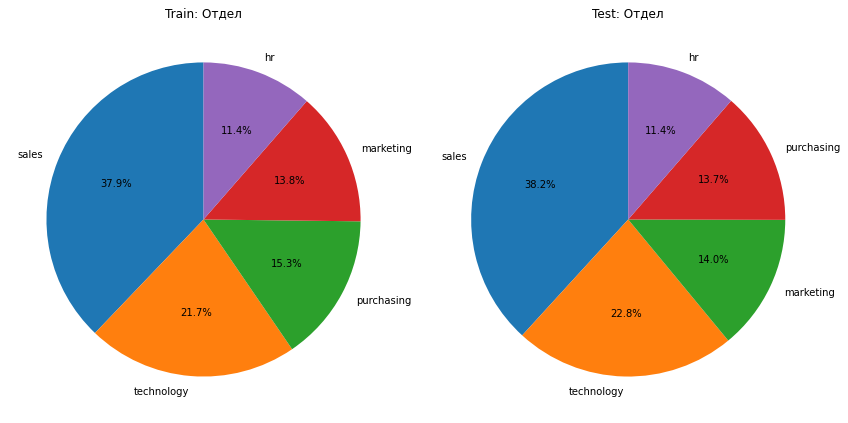

'data_train_job:'

count      3994
unique        5
top       sales
freq       1512
Name: dept, dtype: object

'data_test:'

count      1997
unique        5
top       sales
freq        763
Name: dept, dtype: object

********************************************************************************


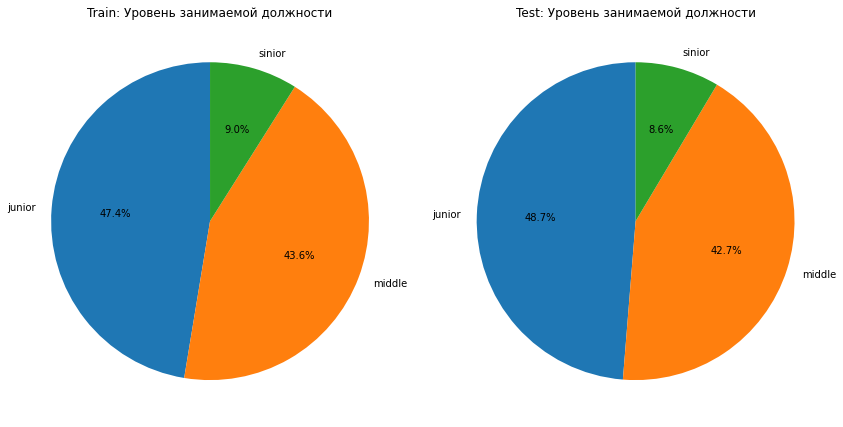

'data_train_job:'

count       3996
unique         3
top       junior
freq        1894
Name: level, dtype: object

'data_test:'

count       1999
unique         3
top       junior
freq         974
Name: level, dtype: object

********************************************************************************


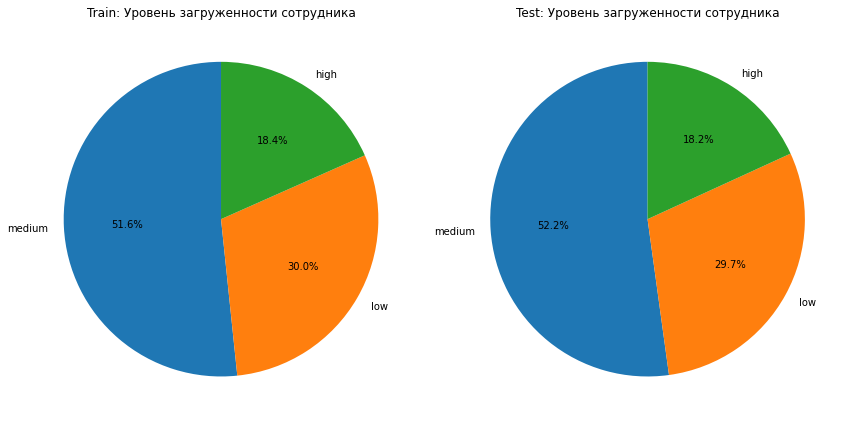

'data_train_job:'

count       4000
unique         3
top       medium
freq        2066
Name: workload, dtype: object

'data_test:'

count       1999
unique         3
top       medium
freq        1043
Name: workload, dtype: object

********************************************************************************


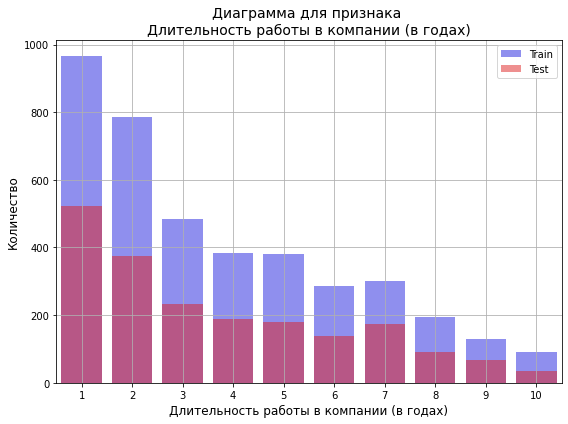

'data_train_job:'

count    4000.000000
mean        3.718500
std         2.542513
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

'data_test:'

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

********************************************************************************


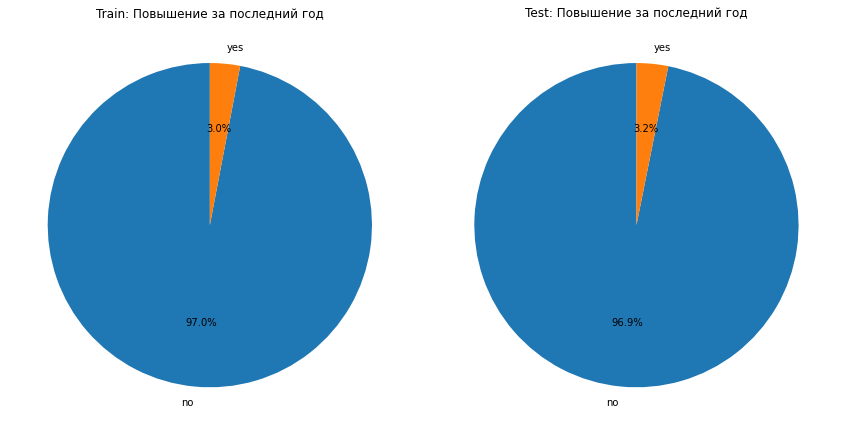

'data_train_job:'

count     4000
unique       2
top         no
freq      3880
Name: last_year_promo, dtype: object

'data_test:'

count     2000
unique       2
top         no
freq      1937
Name: last_year_promo, dtype: object

********************************************************************************


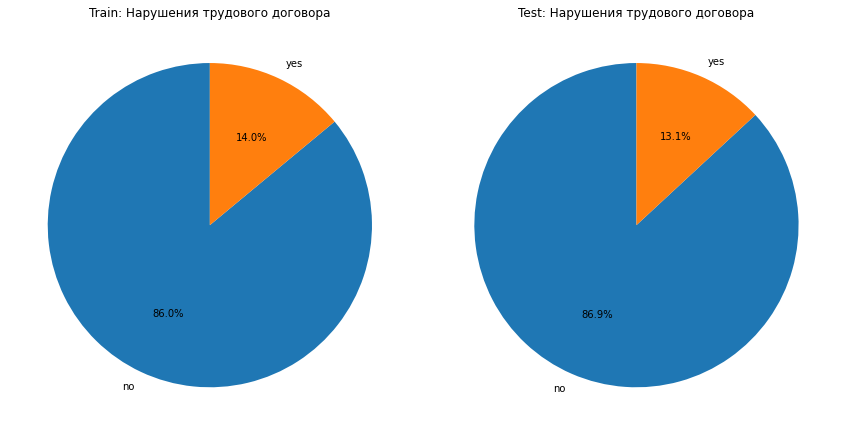

'data_train_job:'

count     4000
unique       2
top         no
freq      3441
Name: last_year_violations, dtype: object

'data_test:'

count     2000
unique       2
top         no
freq      1738
Name: last_year_violations, dtype: object

********************************************************************************


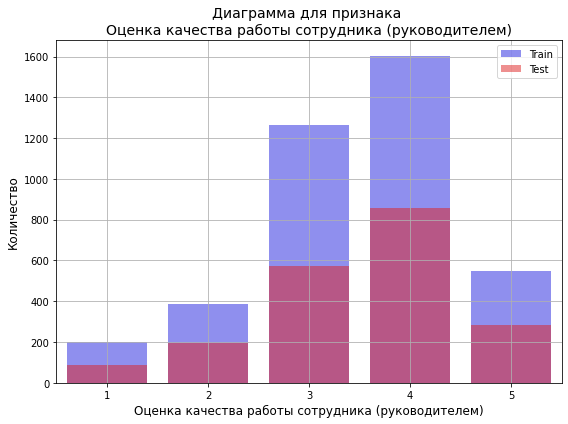

'data_train_job:'

count    4000.000000
mean        3.476500
std         1.008812
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

'data_test:'

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

********************************************************************************


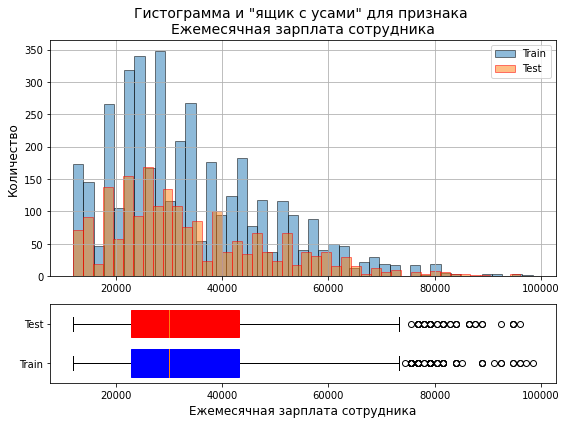

'data_train_job:'

count     4000.000000
mean     33926.700000
std      14900.703838
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      98400.000000
Name: salary, dtype: float64

'data_test:'

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

********************************************************************************


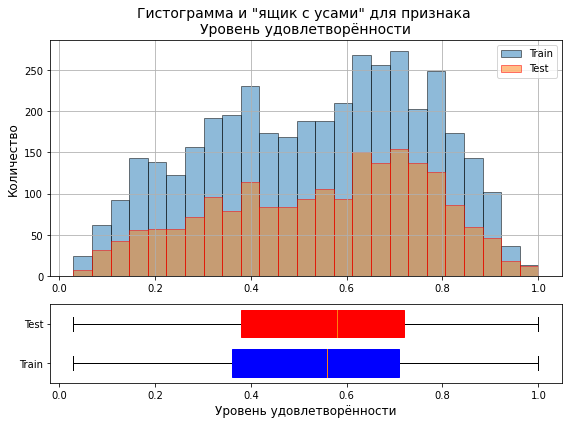

'data_train_job:'

count    4000.000000
mean        0.533995
std         0.225327
min         0.030000
25%         0.360000
50%         0.560000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

'data_test:'

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

********************************************************************************


In [23]:
hist_1(g1_hist, g2_hist, bins_hist, data_train_job, data_test)

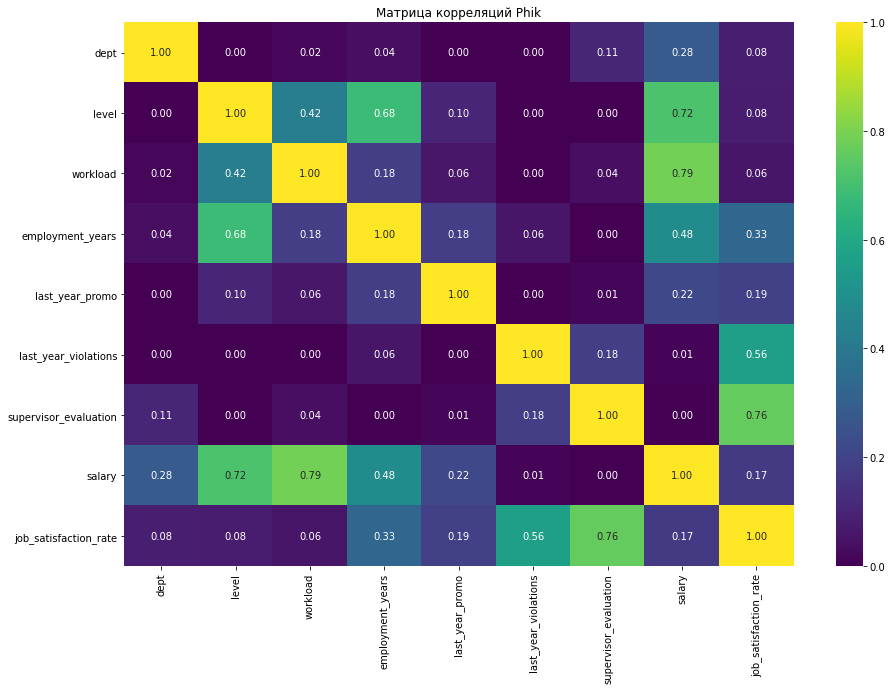

In [24]:
phik_cols = ['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'job_satisfaction_rate']
phik_corr_matrix = (data_train_job[phik_cols]
                    .phik_matrix(interval_cols=['job_satisfaction_rate', 'salary'])
)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Матрица корреляций Phik')
plt.show()

**По круговым диаграммам, гистограммам и "ящикам с усами" тренировочных и тестовых выборок видим следующее… Распределения признаков тренировочной и тестовой выборок имеют  схожий вид:**
- из 5 отделов преобладает отдел sales (около 38%)
- по уровню занимаемой должности работники примерно одинаково, с небольшой разницей, распределены по уровню junior (около 47-48%) и middle (около 43-44%) и около 9% отводится уровню senior.
- по уровню загруженности работника более половины работников имеют загрузку medium.
- Гистограмма по длительности работы в компании имеет вид распределения Пуассона с пиком около 1, среднее и медианные значения не сильно отличаются друг от друга, стандартное отклонение умеренное, выбросов нет.
- 97% работников не получали повышения за последний год
- 86-87% работников не допускали нарушений трудового договора за последний год
- Гистограмма по оценке работника руководителем имеет вид распределения Пуассона с пиком около 4, значения распределены дискретно от 1 до 5, среднее и медианные значения не сильно отличаются друг от друга, стандартное отклонение умеренное.
- Гистограмма ежемесячной зарплаты сотрудников имеет вид распределения Пуассона с пиком около 28000, различия между средним и медианным значениями умеренное, стандартное отклонение умеренное. Выше 74000 «ящик с усами» показывает как выбросы, однако мы их оставим. Это просто редкие, но вполне реальные значения, скорее всего соответствующие руководящим позициям.
- Гистограмма уровни удовлетворенности сотрудников имеет вид распределения Пуассона с пиком около 0.72, различия между средним и медианным значениями небольшое, стандартное отклонение умеренное. Выбросов нет.


**По матрице корреляций видим довольно высокую корреляцию целевого признака с количеством повышейни за последний год, количеством нарушений трудового договора за последний год и оценкой качества работы, которую дал руководитель. Мультиколлинеарность между признаками не наблюдается.**

**Рассмотрим признаки в разрезе уровня удовлетворённости (разделим уровень удовлетворённости условно на высокий с оценкой >=0.5, и низкий с оценкой <0.5).**

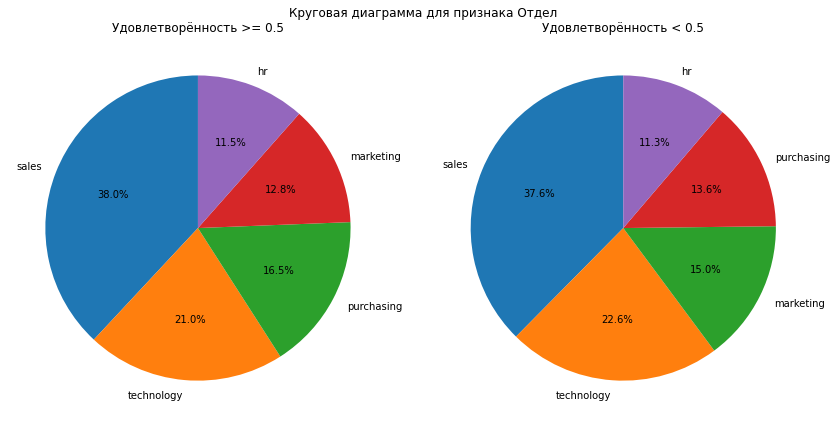

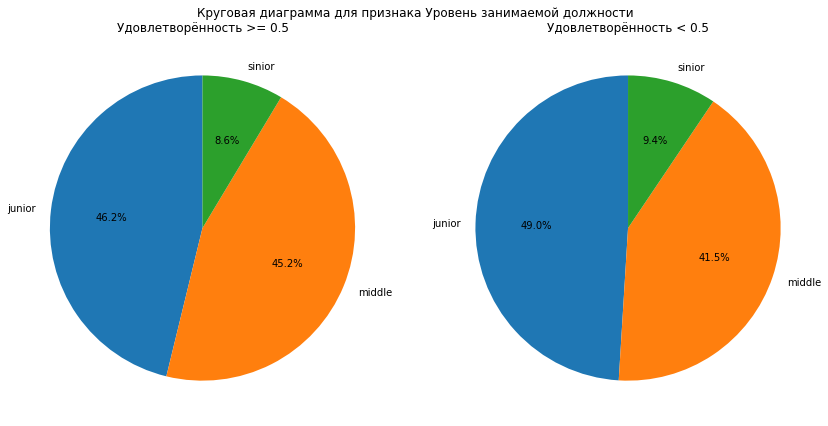

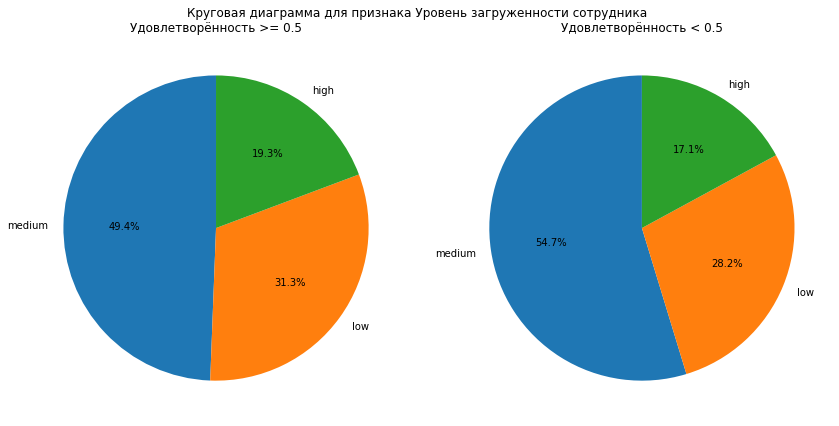

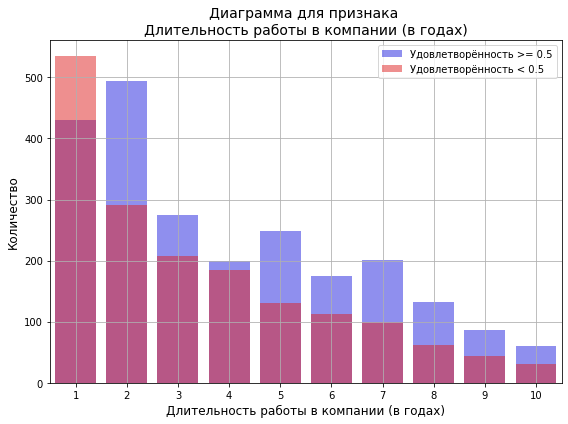

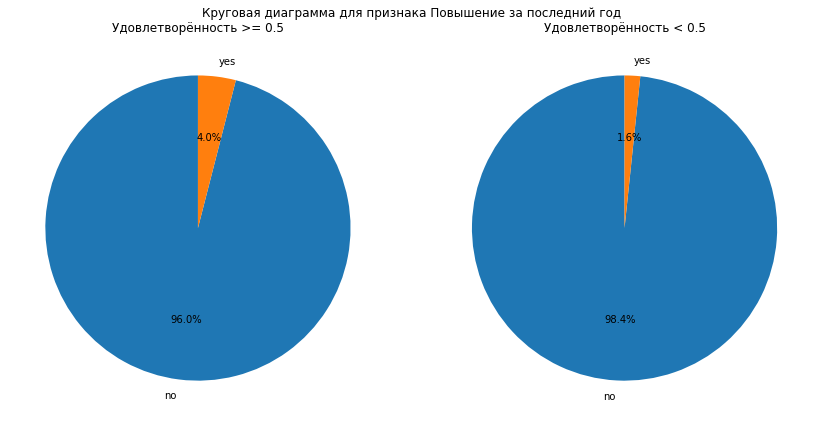

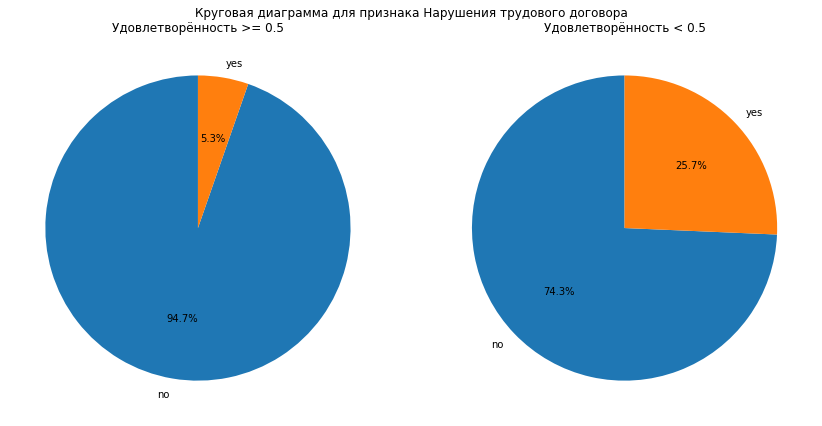

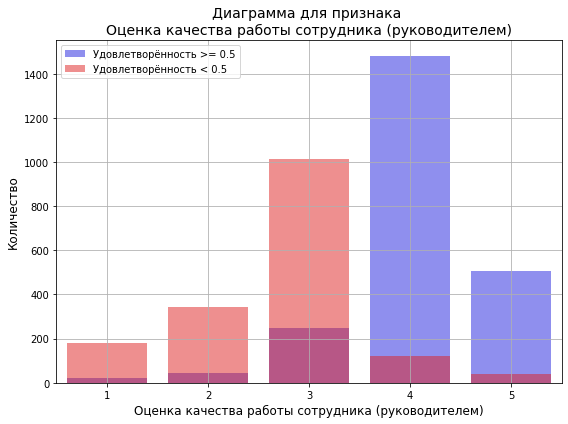

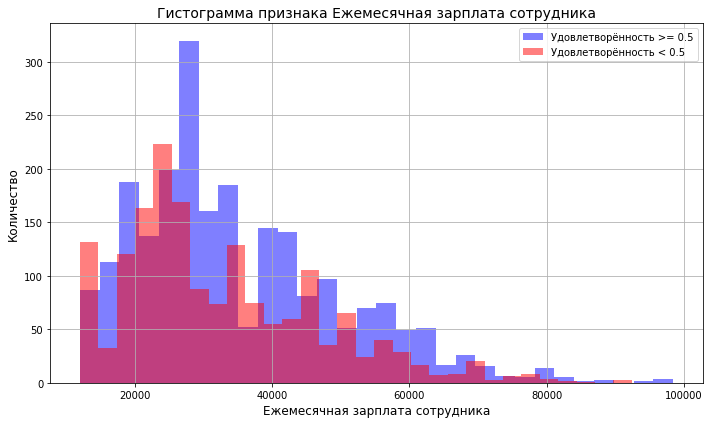

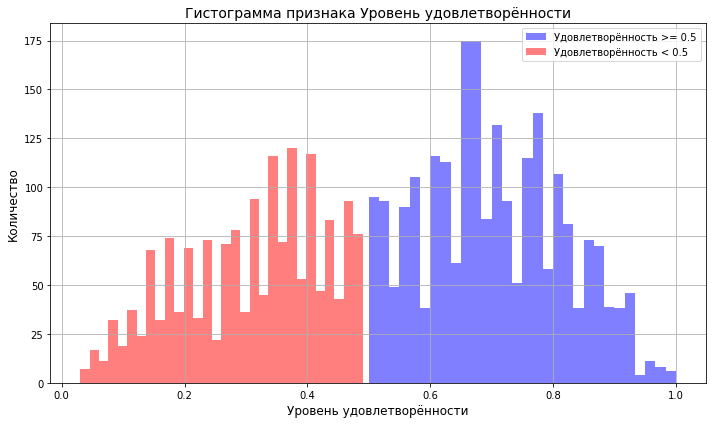

In [25]:
df_jsr_high = data_train_job[data_train_job['job_satisfaction_rate']>=0.5]
df_jsr_low = data_train_job[data_train_job['job_satisfaction_rate']<0.5]
discr_sign = ['employment_years', 'supervisor_evaluation']
for n in range(0,len(g1_hist)):
    if pd.api.types.is_numeric_dtype(data_train_job[g1_hist[n]]) and (g1_hist[n] not in discr_sign):
        plt.figure(figsize=(10, 6))
        plt.hist(df_jsr_high[g1_hist[n]], bins=30, alpha=0.5, label='Удовлетворённость >= 0.5', color='blue')
        plt.hist(df_jsr_low[g1_hist[n]], bins=30, alpha=0.5, label='Удовлетворённость < 0.5', color='red')
        plt.title(f'Гистограмма признака {g2_hist[n]}', fontsize=14)
        plt.ylabel('Количество', fontsize=12)
        plt.xlabel(f'{g2_hist[n]}', fontsize=12)
        plt.grid(True)
        plt.legend()     
        
    elif pd.api.types.is_numeric_dtype(data_train_job[g1_hist[n]]) and (g1_hist[n] in discr_sign):
        fig, ax = plt.subplots(figsize=(8,6))
        sns.countplot(x=df_jsr_high[g1_hist[n]], ax=ax, color='blue', alpha=0.5, label='Удовлетворённость >= 0.5')
        sns.countplot(x=df_jsr_low[g1_hist[n]], ax=ax, color='red', alpha=0.5, label='Удовлетворённость < 0.5')
        ax.set_title(f'Диаграмма для признака \n{g2_hist[n]}', fontsize=14)
        ax.set_ylabel('Количество', fontsize=12)
        ax.set_xlabel(f'{g2_hist[n]}', fontsize=12)
        ax.grid(True)
        ax.legend()      
        
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  
        data_1 = df_jsr_high[g1_hist[n]].value_counts()
        data_2 = df_jsr_low[g1_hist[n]].value_counts()
        ax[0].pie(data_1, labels=data_1.index, autopct='%1.1f%%', startangle=90)
        ax[0].set_title('Удовлетворённость >= 0.5')
        ax[1].pie(data_2, labels=data_2.index, autopct='%1.1f%%', startangle=90)
        ax[1].set_title('Удовлетворённость < 0.5')
              
        plt.suptitle(f'Круговая диаграмма для признака {g2_hist[n]}')  
    plt.tight_layout()
    plt.show()
   

**Видим следующее:**
- по отделам зависимости, по уровню занимаемой должности, по уровню загруженности различия незначительны
- по длительности работы в компании сотрудники с низкой удовлетворенностью имеют меньший показатель (пик на отметке 1 год)
- количество сотрудников с нарушениями трудового договора за последний год среди сотрудников с низким уровнем удовлетворенности в 5 раз выше.
- оценка руководителя качества работы сотрудника ниже у сотрудников с низкой удовлетворенностью
- по уровню ежемесячной зарплаты сотрудники с низким уровнем удовлетворенности имеют зарплату немного ниже (пик на уровне примерно на 5000 меньше, чем у сотрудников с высоким уровнем удовлетворенности)


### Подготовка данных

**Произведём подготовку признаков в пайплайне, дополнив пайплайн шагом предобработки.**

In [26]:
RANDOM_STATE = 42

X_train, y_train = (data_train_job.drop(columns=['job_satisfaction_rate', 'id'], axis=1), 
                    data_train_job['job_satisfaction_rate'])

X_test, y_test = (data_test.drop(columns=['job_satisfaction_rate', 'id'], axis=1), 
                    data_test['job_satisfaction_rate'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations', ]
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

**Пайплайн для подготовки признаков готов, переходим у обучению моделей.**

### Обучение моделей

**Обучим две модели. Возьмём одну линейную модель, а в качестве второй — дерево решений. Так как целевой параметр у нас является непрерывной величиной, используем модели LinearRegression() и DecisionTreeRegressor(). Подберём гиперпараметры,выберем лучшую модель и проверим её качество. Выбор сделаем на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»).**

In [27]:
def smape_score(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [28]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models',  DecisionTreeRegressor(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [ DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 30),
        'models__max_features': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
     # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

smape_scorer = make_scorer(smape_score, greater_is_better=False)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    n_iter = 100,
    scoring=smape_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверим работу модели на тестовой выборке
# рассчитаем прогноз на тестовых данных
y_test_pred = randomized_search.predict(X_test) 

smape_value = smape_score(y_test, y_test_pred)

print(f'Метрика SMAPE на тестовой выборке: {smape_value:.2f}%')
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

**Было обучено 2 модели:**
- DecisionTreeRegressor(),
- LinearRegression().

**Были подобраны гиперпараметры. Во время подготовки данных был использован ColumnTransformer, количественные и категориальные признаки обработаны в пайплайне раздельно, для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler. Лучшей моделью оказалось дерево решений `DecisionTreeRegressor(random_state=42)` с параметрами:**
- 'preprocessor__num': 'passthrough', 
- 'models__max_features': 6, 
- 'models__max_depth': 17.

**Метрика SMAPE лучшей модели на тренировочной выборке: 15.26%**
**Метрика SMAPE на тестовой выборке: 14.57%, что соответствует нашей цели (≤15%).**

### Выводы

**В ходе выполнения задачи 1 было выполнено следующее:**
- Проведена предобработка данных, объединены данные тестовой выборки, удалены неявные дубликаты.
- Провели исследовательский анализ данных, обнаружены взаимосвязи уровня удовлетворенности:
    - с длительностью работы в компании, 
    - с нарушениями трудового договора за последний год, 
    - оценкой руководителя качества работы сотрудника, 
    - небольшую зависимость с уровнем ежемесячной зарплаты
- Провели корреляционный анализ, в ходе которого обнаружили взаимосвязи и убедились в отсутствии мультиколлинеарности между признаками.
- Были сформированы пайплайны, с помощью которых было обучено 2 модели:
    - DecisionTreeRegressor(),
    - LinearRegression().
- Были подобраны гиперпараметры, во время подготовки данных был использован ColumnTransformer, количественные и категориальные признаки обработаны в пайплайне раздельно, для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler.

**Лучшей моделью оказалось дерево решений `DecisionTreeRegressor(random_state=42)` с параметрами:**
- 'preprocessor__num': 'passthrough', 
- 'models__max_features': 6, 
- 'models__max_depth': 17.

**Метрика SMAPE лучшей модели на тренировочной выборке: 15.26%**
**Метрика SMAPE на тестовой выборке: 14.57%, что соответствует нашей цели (≤15%).**

**Дерево решений показало лучшие результаты, на мой взгляд, по причине слабой линейной связи между признаками и целевым признаком, а также в больших возможностях дерева решений в подборе гиперпараметров.**

## **Задача 2: предсказание увольнения сотрудника из компании**

**Для этой задачи будем использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.**

### Загрузка данных

In [29]:
data_train_quit = pd.read_csv('/datasets/train_quit.csv', sep = ',')
data_test_target_quit = pd.read_csv('/datasets/test_target_quit.csv', sep = ',')

In [30]:
inf(data_train_quit, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


None

In [31]:
inf(data_test_target_quit, 10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


None

**Данные загружены, соответствуют описанию. Переходим к предобработке данных.**

### Предобработка данных

**Типы данных в столбцах новых полученных датафреймов соответствуют находящимся в них данным. Наименования столбцов не требуют изменений.**

**Проверим данные на наличие дубликатов.**

In [32]:
data_train_quit.duplicated().sum()

0

In [33]:
data_test_target_quit.duplicated().sum()

0

**Объединим таблицы `data_test_features` и `data_test_target_quit`.**

In [34]:
data_test_quit = data_test_features.merge(data_test_target_quit, on='id', how='inner')

In [35]:
inf(data_test_quit, 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no
5,429973,purchasing,middle,medium,6,no,no,3,42000,yes
6,850699,technology,junior,medium,3,no,no,3,26400,yes
7,500791,sales,middle,high,9,no,no,4,49200,no
8,767867,marketing,middle,high,3,no,yes,4,62400,no
9,937235,sales,junior,medium,1,no,yes,3,26400,yes


None

**По столбцам с типами данных object рассмотрим уникальные значения для проверки на наличие неявных дубликатов.**

In [36]:
for n in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']:
    display(f'Уникальные значения data_train_quit[{n}]:', sorted(data_train_quit[n].unique(), key=str))
    display(f'Уникальные значения data_test_quit[{n}]:', sorted(data_test_quit[n].unique(), key=str))

'Уникальные значения data_train_quit[dept]:'

['hr', 'marketing', 'purchasing', 'sales', 'technology']

'Уникальные значения data_test_quit[dept]:'

[' ', 'hr', 'marketing', nan, 'purchasing', 'sales', 'technology']

'Уникальные значения data_train_quit[level]:'

['junior', 'middle', 'sinior']

'Уникальные значения data_test_quit[level]:'

['junior', 'middle', nan, 'sinior']

'Уникальные значения data_train_quit[workload]:'

['high', 'low', 'medium']

'Уникальные значения data_test_quit[workload]:'

[' ', 'high', 'low', 'medium']

'Уникальные значения data_train_quit[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_test_quit[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_train_quit[last_year_violations]:'

['no', 'yes']

'Уникальные значения data_test_quit[last_year_violations]:'

['no', 'yes']

'Уникальные значения data_train_quit[quit]:'

['no', 'yes']

'Уникальные значения data_test_quit[quit]:'

['no', 'yes']

**Неявных дубликатов не обнаружено, однако видим, что некоторые пропуски в `data_test` выглядят как пробел, что воспринимается как строковое значение. Устраним это.**

In [37]:
data_test_quit['dept'] = data_test_quit['dept'].replace(' ', np.nan)
data_test_quit['workload'] = data_test_quit['workload'].replace(' ', np.nan)

In [38]:
for n in ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']:
    display(f'Уникальные значения data_test_quit[{n}]:', sorted(data_test_quit[n].unique(), key=str))

'Уникальные значения data_test_quit[dept]:'

['hr', 'marketing', nan, 'purchasing', 'sales', 'technology']

'Уникальные значения data_test_quit[level]:'

['junior', 'middle', nan, 'sinior']

'Уникальные значения data_test_quit[workload]:'

['high', 'low', 'medium', nan]

'Уникальные значения data_test_quit[last_year_promo]:'

['no', 'yes']

'Уникальные значения data_test_quit[last_year_violations]:'

['no', 'yes']

In [39]:
data_test_quit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               1999 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
 9   quit                   2000 non-null   object
dtypes: int64(4), object(6)
memory usage: 171.9+ KB


**Видим теперь явные новые пропуски, которые будут заполнены далее в пайплайне. На данный момент предобработка данных завершена, переходим к исследовательскому анализу данных.**

### Исследовательский анализ данных

**Проведём исследовательский анализ данных. Проведём статистический анализ всех признаков в таблицах, построим графики для каждого признака. Для количественных признаков построим гистограммы и "ящики с усами", а для категориальных признаков - круговую диаграмму.**

In [40]:
data_train_quit.columns

Index(['id', 'dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary', 'quit'],
      dtype='object')

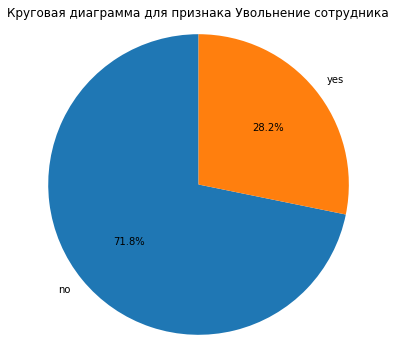

In [41]:
data = data_train_quit['quit'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
plt.title(f'Круговая диаграмма для признака Увольнение сотрудника')
plt.axis('equal')  
plt.show()

**Доля уволившихся сотрудников составляет 28%.**

In [42]:
g1_hist = ['dept', 'level', 'workload', 'employment_years',
       'last_year_promo', 'last_year_violations', 'supervisor_evaluation',
       'salary']
g2_hist = ['Отдел', 'Уровень занимаемой должности', 
           'Уровень загруженности сотрудника', 
           'Длительность работы в компании (в годах)', 
           'Повышение за последний год', 
           'Нарушения трудового договора',
           'Оценка качества работы сотрудника (руководителем)',
           'Ежемесячная зарплата сотрудника']
bins_hist = [30, 30, 30, 30, 30, 30, 30, 45]

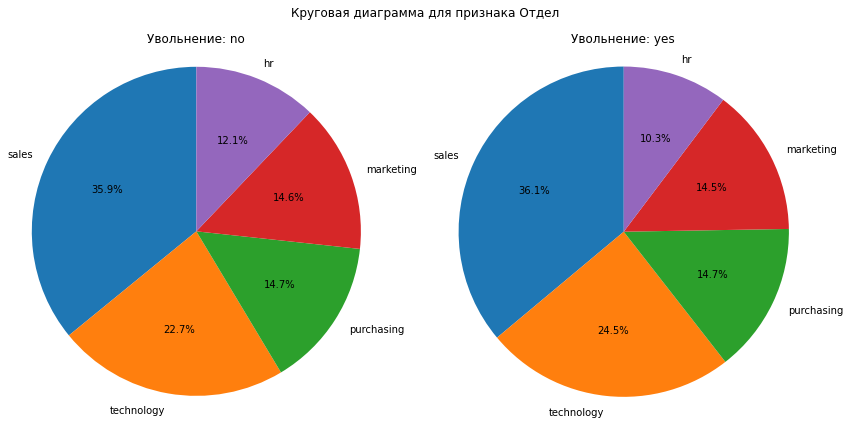

describe: 
Отдел (Увольнение:no): count      2872
unique        5
top       sales
freq       1031
Name: dept, dtype: object

describe: 
Отдел (Увольнение:yes): count      1128
unique        5
top       sales
freq        407
Name: dept, dtype: object

********************************************************************************


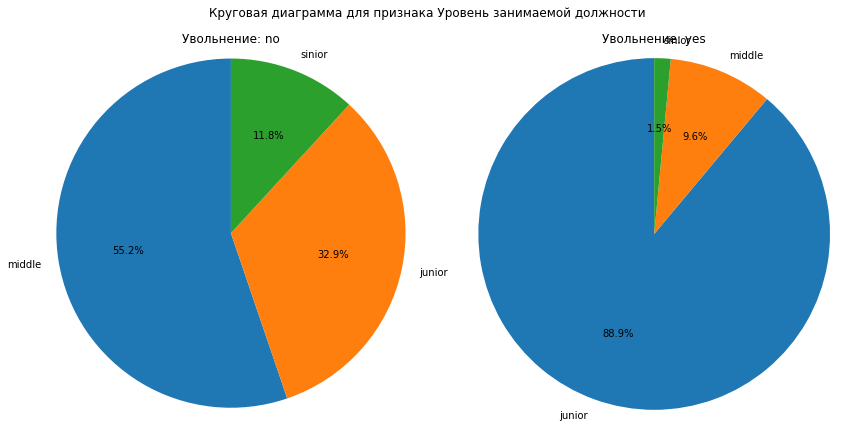

describe: 
Уровень занимаемой должности (Увольнение:no): count       2872
unique         3
top       middle
freq        1586
Name: level, dtype: object

describe: 
Уровень занимаемой должности (Увольнение:yes): count       1128
unique         3
top       junior
freq        1003
Name: level, dtype: object

********************************************************************************


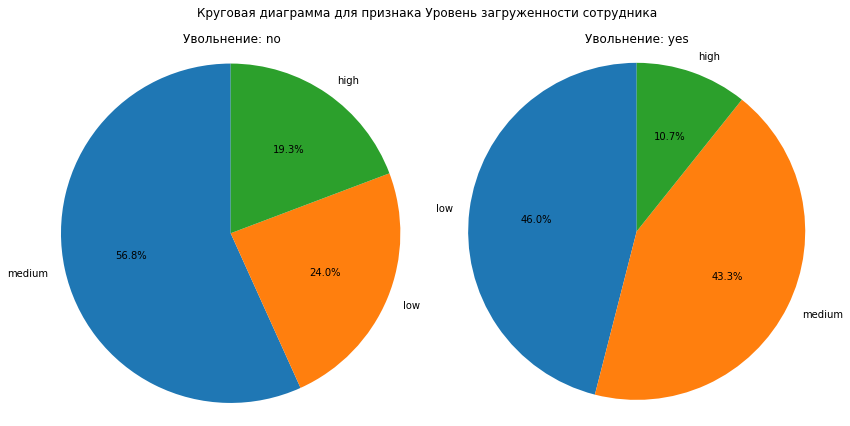

describe: 
Уровень загруженности сотрудника (Увольнение:no): count       2872
unique         3
top       medium
freq        1630
Name: workload, dtype: object

describe: 
Уровень загруженности сотрудника (Увольнение:yes): count     1128
unique       3
top        low
freq       519
Name: workload, dtype: object

********************************************************************************


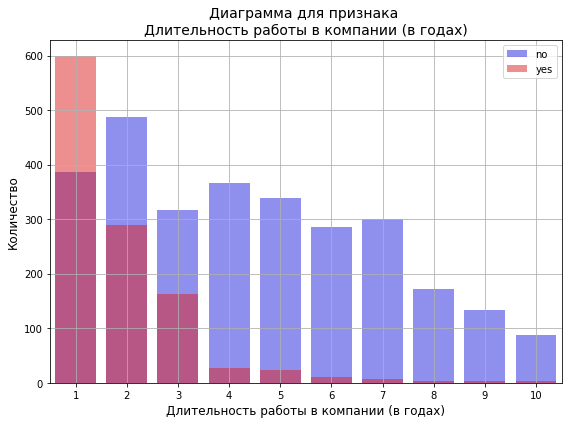

describe: 
Длительность работы в компании (в годах) (Увольнение:no): count    2872.000000
mean        4.430710
std         2.544635
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

describe: 
Длительность работы в компании (в годах) (Увольнение:yes): count    1128.000000
mean        1.844858
std         1.274920
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        10.000000
Name: employment_years, dtype: float64

********************************************************************************


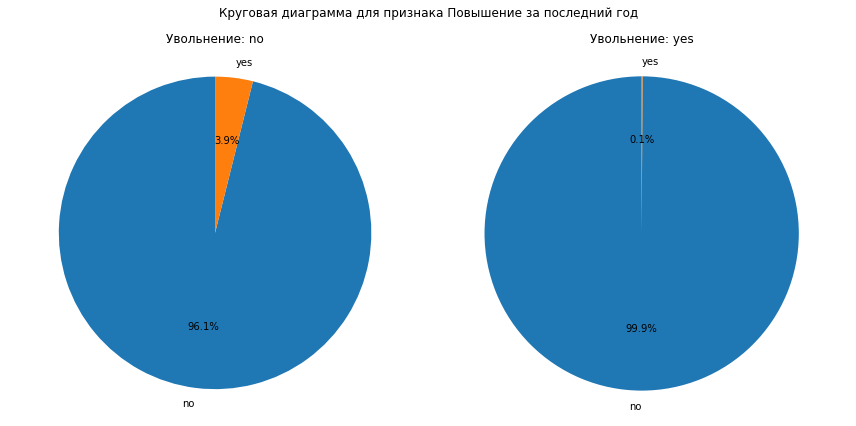

describe: 
Повышение за последний год (Увольнение:no): count     2872
unique       2
top         no
freq      2760
Name: last_year_promo, dtype: object

describe: 
Повышение за последний год (Увольнение:yes): count     1128
unique       2
top         no
freq      1127
Name: last_year_promo, dtype: object

********************************************************************************


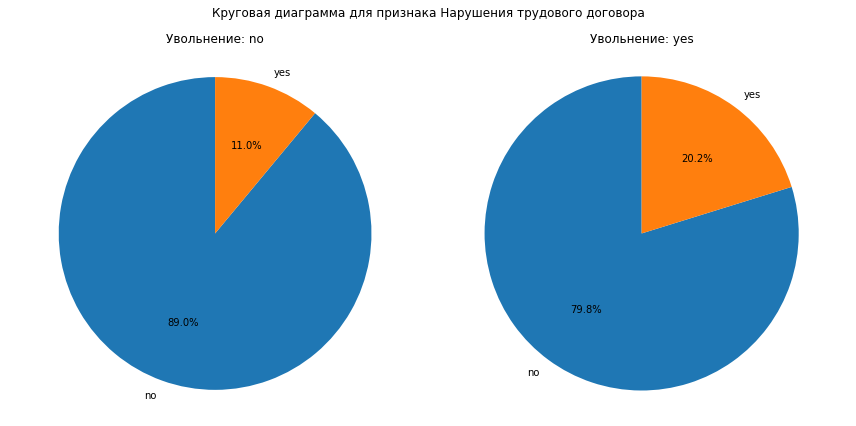

describe: 
Нарушения трудового договора (Увольнение:no): count     2872
unique       2
top         no
freq      2555
Name: last_year_violations, dtype: object

describe: 
Нарушения трудового договора (Увольнение:yes): count     1128
unique       2
top         no
freq       900
Name: last_year_violations, dtype: object

********************************************************************************


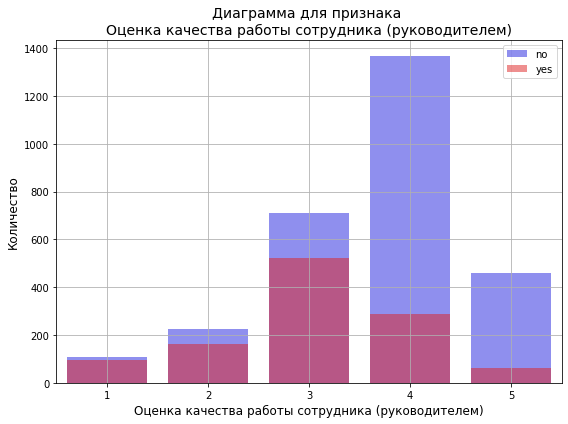

describe: 
Оценка качества работы сотрудника (руководителем) (Увольнение:no): count    2872.000000
mean        3.643106
std         0.965295
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

describe: 
Оценка качества работы сотрудника (руководителем) (Увольнение:yes): count    1128.000000
mean        3.046099
std         0.973291
min         1.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

********************************************************************************


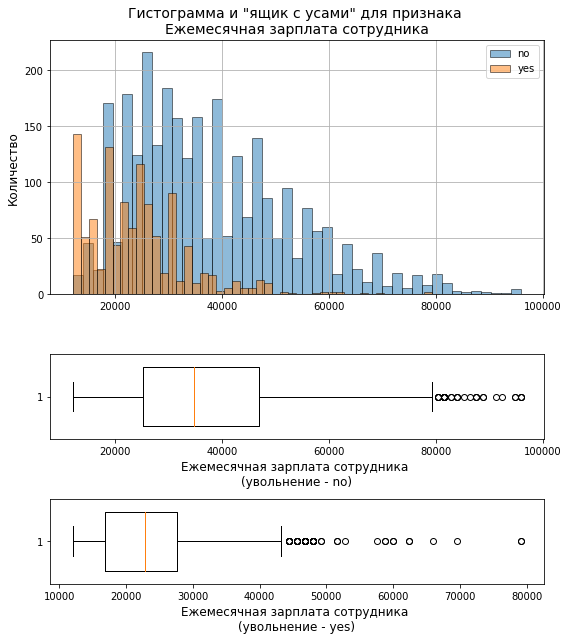

describe: 
Ежемесячная зарплата сотрудника (Увольнение:no): count     2872.000000
mean     37702.228412
std      15218.977339
min      12000.000000
25%      25200.000000
50%      34800.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64

describe: 
Ежемесячная зарплата сотрудника (Увольнение:yes): count     1128.000000
mean     23885.106383
std       9351.599505
min      12000.000000
25%      16800.000000
50%      22800.000000
75%      27600.000000
max      79200.000000
Name: salary, dtype: float64

********************************************************************************


In [43]:
for n in range(0,len(g1_hist)):
    if pd.api.types.is_numeric_dtype(data_train_quit[g1_hist[n]]) and (g1_hist[n] not in discr_sign):
        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 9), gridspec_kw={'height_ratios': [3, 1, 1]})
        for q in data_train_quit['quit'].unique():
            subset = data_train_quit[data_train_quit['quit'] == q]
            ax[0].hist(subset[g1_hist[n]], bins=bins_hist[n], alpha=0.5, edgecolor='black', label=q)
            ax[0].set_title(f'Гистограмма и "ящик с усами" для признака \n{g2_hist[n]}', fontsize=14)
            ax[0].set_ylabel('Количество', fontsize=12)
            ax[0].grid(True)
            ax[0].legend()
        uniq = data_train_quit['quit'].unique()
        ax[1].boxplot(data_train_quit[data_train_quit['quit']==uniq[0]][g1_hist[n]], vert=False, widths=0.7)
        ax[1].set_xlabel(f'{g2_hist[n]} \n(увольнение - {uniq[0]})', fontsize=12)
        ax[2].boxplot(data_train_quit[data_train_quit['quit']==uniq[1]][g1_hist[n]], vert=False, widths=0.7)
        ax[2].set_xlabel(f'{g2_hist[n]} \n(увольнение - {uniq[1]})', fontsize=12) 
        
    elif pd.api.types.is_numeric_dtype(data_train_job[g1_hist[n]]) and (g1_hist[n] in discr_sign):
            fig, ax = plt.subplots(figsize=(8,6))
            q = data_train_quit['quit'].unique()
            subset_1 = data_train_quit[data_train_quit['quit'] == q[0]]  
            subset_2 = data_train_quit[data_train_quit['quit'] == q[1]]   
            sns.countplot(x=subset_1[g1_hist[n]], ax=ax, color='blue', alpha=0.5, label=q[0])
            sns.countplot(x=subset_2[g1_hist[n]], ax=ax, color='red', alpha=0.5, label=q[1])
            ax.set_title(f'Диаграмма для признака \n{g2_hist[n]}', fontsize=14)
            ax.set_ylabel('Количество', fontsize=12)
            ax.set_xlabel(f'{g2_hist[n]}', fontsize=12)
            ax.grid(True)
            ax.legend()        
        
        
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))  
        for i, q in enumerate(data_train_quit['quit'].unique()):
            subset = data_train_quit[data_train_quit['quit'] == q]
            data = subset[g1_hist[n]].value_counts()
            ax[i].pie(data, labels=data.index, autopct='%1.1f%%', startangle=90)
            ax[i].set_title(f'Увольнение: {q}')  
            ax[i].axis('equal')  
        plt.suptitle(f'Круговая диаграмма для признака {g2_hist[n]}')  
    plt.tight_layout()
    plt.show()
    for q in data_train_quit['quit'].unique():
        print(f'describe: \n{g2_hist[n]} (Увольнение:{q}):', 
              data_train_quit[data_train_quit['quit'] == q][g1_hist[n]].describe(include='all'))
        print()
    print(80*'*')

**По гистограммам и круговым диаграммам можем составить следующий портрет «уволившегося сотрудника»:**
- Взаимосвязь с отделом сотрудника не наблюдается
-  По уровню занимаемой должности подавляющее большинство увольнений приходится на уровень junior (89%)
- По уровню загруженности наибольшее количество увольнений приходится на низкий уровень загруженности (low), что в 2 раза выше доли работающих с этим же уровнем загруженности
- Подавляющее большинство уволившихся проработали в компании 1-3 года, средний срок работы более чем в 2 раза меньше среднего срока у работающих сотрудников (1.84 против 4.43)
- по доли повышений за последний год у уволившихся меньше, чем у работающих (0.1% против 3.9%)
- Нарушений трудового договора у уволившихся за последний год было в 2 раза больше, чем у работающих (20% против 11%)
- средняя оценка качества работы сотрудника, данная  руководителем, у уволившихся ниже, чем у работающих
- уровень ежемесячной зарплаты у уволившихся в 1.5 раза меньше, чем у работающих

**Добавим в таблицу уровень удовлетворённости.**

In [44]:
data_test_quit_satis = data_test_target_quit.merge(data_test_target, on='id', how='inner')

In [45]:
inf(data_test_quit_satis,10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   quit                   2000 non-null   object 
 2   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB


,id,quit,job_satisfaction_rate
0,999029,yes,0.35
1,372846,no,0.21
2,726767,no,0.73
3,490105,no,0.62
4,416898,yes,0.57
5,223063,no,0.75
6,810370,no,0.65
7,998900,no,0.57
8,578329,no,0.60
9,648850,no,0.79


None

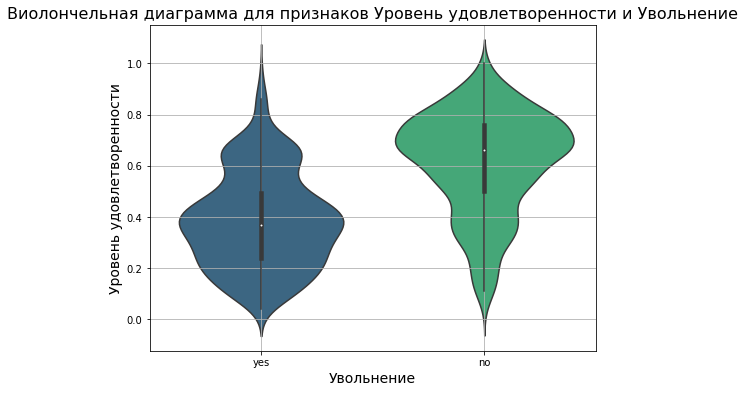

In [46]:
plt.figure(figsize=(8, 6))
sns.violinplot(data=data_test_quit_satis, y='job_satisfaction_rate', x='quit', palette='viridis')
plt.title('Виолончельная диаграмма для признаков Уровень удовлетворенности и Увольнение', fontsize=16)
plt.xlabel('Увольнение', fontsize=14)
plt.ylabel('Уровень удовлетворенности', fontsize=14)
plt.grid(True)
plt.show()

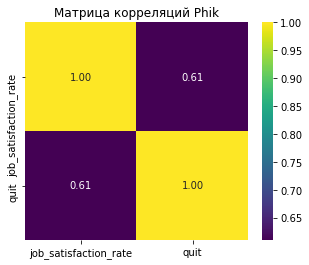

In [47]:
phik_cols = ['job_satisfaction_rate', 'quit']
phik_corr_matrix = (data_test_quit_satis[phik_cols]
                    .phik_matrix(interval_cols=['job_satisfaction_rate'])
)
plt.figure(figsize=(5, 4))
sns.heatmap(phik_corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Матрица корреляций Phik')
plt.show()

**По виолончельной диаграмме видим взаимосвязь между уровнем удовлетворенности сотрудников и вероятностью увольнения. У уволившихся сотрудников больше плотность низких значений уровня удовлетворенности, а у работающих - высоких значений уровня удовлетворенности. Эта взаимосвязь также подтверждается довольно высоким уровнем корреляции между данными признаками.**

**В ходе исследовательского анализа было выполнено следующее:**
- Составлен портрет «уволившегося сотрудника»:
    - по уровню занимаемой должности подавляющее большинство увольнений приходится на уровень junior (89%)
    - по уровню загруженности наибольшее количество увольнений приходится на низкий уровень загруженности (low)
    - подавляющее большинство уволившихся проработали в компании 1-3 года
    - по доли повышений за последний год у уволившихся меньше, чем у работающих
    - нарушений трудового договора у уволившихся за последний год было в 2 раза больше, чем у работающих
    - средняя оценка качества работы сотрудника, данная  руководителем, у уволившихся ниже, чем у работающих
    - уровень ежемесячной зарплаты у уволившихся меньше, чем у работающих
- Выявлена взаимосвязь между уровнем удовлетворенности сотрудников и вероятностью увольнения.

### Добавление нового входного признака

**Добавим `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.**

In [48]:
data_train_quit['job_satisfaction_rate_pred'] = randomized_search.predict(data_train_quit) 

In [49]:
data_test_quit['job_satisfaction_rate_pred'] = randomized_search.predict(data_test_quit) 

In [50]:
inf(data_train_quit, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          4000 non-null   int64  
 1   dept                        4000 non-null   object 
 2   level                       4000 non-null   object 
 3   workload                    4000 non-null   object 
 4   employment_years            4000 non-null   int64  
 5   last_year_promo             4000 non-null   object 
 6   last_year_violations        4000 non-null   object 
 7   supervisor_evaluation       4000 non-null   int64  
 8   salary                      4000 non-null   int64  
 9   quit                        4000 non-null   object 
 10  job_satisfaction_rate_pred  4000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 343.9+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.600000
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.826111
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.380000
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


None

In [51]:
inf(data_test_quit, 5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          2000 non-null   int64  
 1   dept                        1997 non-null   object 
 2   level                       1999 non-null   object 
 3   workload                    1999 non-null   object 
 4   employment_years            2000 non-null   int64  
 5   last_year_promo             2000 non-null   object 
 6   last_year_violations        2000 non-null   object 
 7   supervisor_evaluation       2000 non-null   int64  
 8   salary                      2000 non-null   int64  
 9   quit                        2000 non-null   object 
 10  job_satisfaction_rate_pred  2000 non-null   float64
dtypes: float64(1), int64(4), object(6)
memory usage: 187.5+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,no,0.866667
1,686555,hr,junior,medium,1,no,no,4,30000,no,0.681429
2,467458,sales,middle,low,5,no,no,4,19200,no,0.657143
3,418655,sales,middle,low,6,no,no,4,19200,no,0.655000
4,789145,hr,middle,medium,5,no,no,5,40800,no,0.799000


None

### Подготовка данных

**Подготовим признаки так же, как и в первой задаче: выполним подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учтем особенности признаков и моделей и используем два кодировщика.**

In [52]:
RANDOM_STATE = 42

label_encoder = LabelEncoder()
data_train_quit['quit'] = label_encoder.fit_transform(data_train_quit['quit'])

X_train, y_train = (data_train_quit.drop(columns=['quit', 'id'], axis=1), 
                    data_train_quit['quit'])

X_test, y_test = (data_test_quit.drop(columns=['quit', 'id'], axis=1), 
                    data_test_quit['quit'])

X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations', ]
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

### Обучение модели

**Обучим 4 модели, подберем гиперпараметры, проверим качество лучшей модели. Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC≥0.91 на тестовой выборке. Целевой признак у нас бинарный, будем использовать модели классификации.**

In [53]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'sigmoid', 'poly', 'rbf'],
        'models__degree': range(2, 6),
        'models__C': np.linspace(0.1, 1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')
print(f'Параметры лучшей модели: {randomized_search.best_params_}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

**Метрика ROC-AUC соответствует установленным критериям успеха.**

### Вывод

**В ходе выполнения задачи 2 было выполнено следующее:**
- Проведена предобработка данных, объединены данные тестовой выборки, удалены неявные дубликаты.
- Провели исследовательский анализ данных.
- Составлен портрет «уволившегося сотрудника»:
    - по уровню занимаемой должности подавляющее большинство увольнений приходится на уровень junior (89%)
    - по уровню загруженности наибольшее количество увольнений приходится на низкий уровень загруженности (low)
    - подавляющее большинство уволившихся проработали в компании 1-3 года
    - по доли повышений за последний год у уволившихся меньше, чем у работающих
    - нарушений трудового договора у уволившихся за последний год было в 2 раза больше, чем у работающих
    - средняя оценка качества работы сотрудника, данная  руководителем, у уволившихся ниже, чем у работающих
    - уровень ежемесячной зарплаты у уволившихся меньше, чем у работающих
- Выявлена взаимосвязь между уровнем удовлетворенности сотрудников и вероятностью увольнения.
- Добавлен новый входной признак.
- Были сформированы пайплайны, с помощью которых было обучено 4 модели:
    - KNeighborsClassifier(), 
    - DecisionTreeClassifier(), 
    - LogisticRegression(), 
    - SVC(). 

**Для каждой из моделей были подобраны гиперпараметры.  Во время подготовки данных был использован ColumnTransformer. Количественные и категориальные признаки обработаны в пайплайне раздельно. Для кодирования категориальных признаков использованы OneHotEncoder и OrdinalEncoder, для масштабирования количественных — StandardScaler и MinMaxScaler.**
**Лучшей моделью оказался метод опорных векторов (SVC) с параметрами:**
- ядро радиальной базисной функции (RBF)
- параметр регуляризации С = 0.9
- probability=True
- метод масштабирования StandardScaler()

**Метрика лучшей модели на тренировочной выборке: 0.93**

**Метрика ROC-AUC на тестовой выборке: 0.93**

**В данном случае лучшие результаты показал метод опорных векторов с ядром радиальной базисной функции (RBF) благодаря правильно подобранным параметрам, в том числе параметра регуляризации С, что позволило модели найти подходящий баланс между сложностью модели и ошибкой на обучающей выборке.**

## **Общий вывод**

**HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.**
**В ходе выполнения проекта были выполнены 2 задачи, в ходе которых были:**
- проведена предобработка данных, 
- исследовательский анализ данных, обнаружены взаимосвязи целевых признаков. 
- с помощью пайплайнов подготовлены данные и обучены модели.

**В первой задаче целевой признак был непрерывным, а во второй - бинарным, поэтому модели использовались разные.**
**В результате, с помощью машинного обучения мы получаем предсказания двух важных для бизнеса целевых признаков:**
- удовлетворенность сотрудников,
- предсказание увольнения сотрудников.


**Хочется обратить внимание бизнеса на признаки, которые связаны с целевыми признаками:**
- Уровень удовлетворенности связан с:
    - с длительностью работы в компании,
    - с нарушениями трудового договора за последний год,
    - оценкой руководителя качества работы сотрудника,
    - с уровнем ежемесячной зарплаты
- Портрет «уволившегося сотрудника»:
    - по уровню занимаемой должности подавляющее большинство увольнений приходится на уровень junior (89%)
    - по уровню загруженности наибольшее количество увольнений приходится на низкий уровень загруженности (low)
    - подавляющее большинство уволившихся проработали в компании 1-3 года
    - по доли повышений за последний год у уволившихся меньше, чем у работающих
    - нарушений трудового договора у уволившихся за последний год было в 2 раза больше, чем у работающих
    - средняя оценка качества работы сотрудника, данная  руководителем, у уволившихся ниже, чем у работающих
    - уровень ежемесячной зарплаты у уволившихся меньше, чем у работающих
- Выявлена взаимосвязь между уровнем удовлетворенности сотрудников и вероятностью увольнения.

**Рекомендации:**
- осуществлять регулярный мониторинг рынка труда на предмет конкурентности заработной платы компании
- в случае отсутствия таковой, внедрить систему наставничества для "молодых" работников с целью более лёгкой адаптации на рабочем месте на начальном этапе, контроля загруженности, а также активного развития
- продумать систему материальной и нематериальной мотивации для повышения личной заинтересованности в повышении качества работы.